# Meteo conversion optimisation for hydro models

We will go in details of how to convert meteorological data (ECMWF/ERA5): 
 * from netcdf gridded data 

 ![ECMWF](https://climate.copernicus.eu/sites/default/files/inline-images/CERRA_wind.png)
 * onto zarr unstrutured meshes format 
 
 ![global mesh](assets/ERA5_wind.gif)

The idea is to able to prepare the data to be able to use it as an input for our hydro models (SCHISM & TELEMAC) used at JRC

## 1 - Sensitivity on the chunking size

### Important! first write an empty array
> Dimensions cannot be included in both `region` and `append_dim` at the same time. To create empty arrays to fill in with `region`, use a separate call to `to_zarr()` with `compute=False.`

the first step consists in creating an initial Zarr dummy Dataset array.

In [1]:
import dask.array as da
import numpy as np
import hvplot.pandas
import pandas as pd
import holoviews as hv
from holoviews import opts
import pandas as pd
import xarray as xr
import shutil
import os
import time

In [2]:
# Set up parameters for the dataset
NTIMES = 744     # one month hourly
NNODES = 100000  # 100k nodes
chunk_size_time = 10  # Choose an appropriate chunk size for the time dimension

In [3]:
zero = da.empty((NTIMES, NNODES), chunks=(chunk_size_time, NNODES))
zero

dask.array<empty_like, shape=(744, 100000), dtype=float64, chunksize=(10, 100000), chunktype=numpy.ndarray>

what about if we had a dimension for the variables?

In [4]:
NVAR = 4
cube_zero = da.empty((NTIMES,NVAR, NNODES), chunks=(chunk_size_time, 1, NNODES))
cube_zero

dask.array<empty_like, shape=(744, 4, 100000), dtype=float64, chunksize=(10, 1, 100000), chunktype=numpy.ndarray>

In [6]:
# Write the data to a temporary Zarr store
tmp = 'tmp.zarr'
ds = xr.Dataset({
    "u10": (('time', 'node'), zero),
    "v10": (('time', 'node'), zero),
    "msl": (('time', 'node'), zero),
    "tmp": (('time', 'node'), zero),
     
})
ds.to_zarr(tmp, compute=False)

Delayed('_finalize_store-10e723ec-5be9-4a47-ab99-acbe8dcc6b8f')

we generated a metadata file, which will help us to aggregate the data later on. 

In [7]:
!cat tmp.zarr/.zmetadata

{
    "metadata": {
        ".zattrs": {},
        ".zgroup": {
            "zarr_format": 2
        },
        "msl/.zarray": {
            "chunks": [
                10,
                100000
            ],
            "compressor": {
                "blocksize": 0,
                "clevel": 5,
                "cname": "lz4",
                "id": "blosc",
                "shuffle": 1
            },
            "dtype": "<f8",
            "fill_value": "NaN",
            "filters": null,
            "order": "C",
            "shape": [
                744,
                100000
            ],
            "zarr_format": 2
        },
        "msl/.zattrs": {
            "_ARRAY_DIMENSIONS": [
                "time",
                "node"
            ]
        },
        "tmp/.zarray": {
            "chunks": [
                10,
                100000
            ],
            "compressor": {
                "blocksize": 0,
                "clevel": 5,
                "cname": "l

we'll put everything in a function to calculate the time taken to write data, depending on : 
 * the chunk size on the `time` dimention 
 * the chunk size on the `node` dimention 

In [8]:
def test_chunk_size(n_time_chunk, n_node_chunk):
    start = time.time()
    tmp = 'tmp.zarr'
    if os.path.exists(tmp):
        shutil.rmtree(tmp)
    # create attrs and file 
    zero = da.empty((NTIMES, NNODES), chunks=(n_time_chunk, n_node_chunk))
    bytes_per_element = zero.dtype.itemsize
    chunk_size_mb = n_time_chunk * n_node_chunk * bytes_per_element  / 1024 / 1000
    if chunk_size_mb > 2000: 
        return np.nan, np.nan
    else: 
        ds = xr.Dataset({
        "u10": (('time', 'node'), zero),
        "v10": (('time', 'node'), zero),
        "msl": (('time', 'node'), zero),
        "tmp": (('time', 'node'), zero), 
        }).to_zarr(tmp, compute=False)
        # Create a Pandas date range for the time coordinates
        time_range = pd.date_range(start=pd.Timestamp(2023, 1, 1), periods=NTIMES, freq='h')
        # Loop over variables
        count = 0
        for var_name in ["u10", "v10", "msl", "tmp"]:
            # Loop over time in chunks
            for t_start in range(0, NTIMES, n_time_chunk):
                t_end = min(t_start + n_time_chunk, NTIMES)
                time_chunk = time_range[t_start:t_end]
                # Loop over nodes in chunks
                for i_node in range(0, NNODES, n_node_chunk):
                    end_node = min(i_node + n_node_chunk, NNODES)
                    data_chunk = np.random.random((t_end - t_start) * (end_node - i_node))
                    data_chunk = data_chunk.reshape((t_end - t_start, end_node - i_node))
                    node_chunk = np.arange(i_node, end_node)
                    coords = {'node': node_chunk, 'time':time_chunk}
                    ds = xr.Dataset({var_name: (('time', 'node'), data_chunk)}, coords=coords)
                    region = {'time': slice(t_start, t_end), 'node': slice(i_node, end_node)}
                    ds.to_zarr(tmp, mode="a-", region=region)
                    count += 1
        
        end = time.time()
        print(f"Chunk size: times:{n_time_chunk} x nodes:{n_node_chunk} - {chunk_size_mb}kB")
        return end - start, chunk_size_mb

Iterate for a range of chunk sizes

In [9]:
chunksizes =  [10, 50, 100, 150, 200, 250, 300, 350, 400, 500]
nodessizes =  [5000, 10000, 50000, 100000]#, 500000, 1000000]

time_perf = np.zeros((len(chunksizes), len(nodessizes)))
sizes = np.zeros((len(chunksizes), len(nodessizes)))
for i_t, chunktime in enumerate(chunksizes): 
    for i_n, chunknode in enumerate(nodessizes):
        perf, size = test_chunk_size(chunktime, chunknode)
        time_perf[i_t,i_n] = perf
        sizes[i_t,i_n] = size

Chunk size: times:10 x nodes:5000 - 0.390625kB
Chunk size: times:10 x nodes:10000 - 0.78125kB
Chunk size: times:10 x nodes:50000 - 3.90625kB
Chunk size: times:10 x nodes:100000 - 7.8125kB
Chunk size: times:50 x nodes:5000 - 1.953125kB
Chunk size: times:50 x nodes:10000 - 3.90625kB
Chunk size: times:50 x nodes:50000 - 19.53125kB
Chunk size: times:50 x nodes:100000 - 39.0625kB
Chunk size: times:100 x nodes:5000 - 3.90625kB
Chunk size: times:100 x nodes:10000 - 7.8125kB
Chunk size: times:100 x nodes:50000 - 39.0625kB
Chunk size: times:100 x nodes:100000 - 78.125kB
Chunk size: times:150 x nodes:5000 - 5.859375kB
Chunk size: times:150 x nodes:10000 - 11.71875kB
Chunk size: times:150 x nodes:50000 - 58.59375kB
Chunk size: times:150 x nodes:100000 - 117.1875kB
Chunk size: times:200 x nodes:5000 - 7.8125kB
Chunk size: times:200 x nodes:10000 - 15.625kB
Chunk size: times:200 x nodes:50000 - 78.125kB
Chunk size: times:200 x nodes:100000 - 156.25kB
Chunk size: times:250 x nodes:5000 - 9.765625kB


In [10]:
# Convert data for pcolormesh plots into a format compatible with hvplot
time_perf_mesh_df = pd.DataFrame(time_perf, index=chunksizes, columns=nodessizes)
sizes_mesh_df = pd.DataFrame(sizes, index=chunksizes, columns=nodessizes)

# Convert data for line plot into a Pandas DataFrame
sizes_flat = sizes.ravel()
time_perf_flat = time_perf.ravel()
idx = np.argsort(sizes_flat)
line_df = pd.DataFrame({
    'Size (MB)': sizes_flat[idx],
    'Time (sec)': time_perf_flat[idx]
})

options = {
    "x":'columns', 
    "y":'index', 
    "C":'value', 
    "logx":True, 
    "colorbar":True, 
    "xlabel":"chunk size for nodes", 
    "ylabel" : "chunk size for times", 
    "width" : 500,
}

# Create hvplot pcolormesh plots
time_perf_plot = time_perf_mesh_df.hvplot.heatmap(title = 'Time taken for the export (in seconds)', **options)
sizes_plot = sizes_mesh_df.hvplot.heatmap(title='Size of each chunk (in MB)', **options)

# Create hvplot line plot
line_plot = line_df.hvplot.line(
    x='Size (MB)', y='Time (sec)', 
    title='Time taken vs. Size of each chunk', width = 500)

# Combine plots into a layout
layout = (time_perf_plot + sizes_plot + line_plot).cols(3)

# Apply some options for better layout
layout.opts(
    opts.HeatMap(colorbar=True),
    opts.Layout(shared_axes=False, merge_tools=False),
)
# # Display the layout
hv.output(layout)

:Layout
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .HeatMap.II :HeatMap   [columns,index]   (value)
   .Curve.I    :Curve   [Size (MB)]   (Time (sec))

Conclusion: that the bigger the chunk size is, the smaller is the time to process the data. 

## 2 - test with real data

We used previously the `region` parameter to append chunks to the zarr file.

According to the [docs](https://docs.xarray.dev/en/stable/user-guide/io.html#modifying-existing-zarr-stores), 
> region (`dict` or `"auto"`, optional) – Optional mapping from dimension names to integer slices along dataset dimensions to indicate the region of existing zarr array(s) in which to write this dataset’s data. For example, `{'x': slice(0, 1000), 'y': slice(10000, 11000)}` would indicate that values should be written to the region `0:1000` along `x` and `10000:11000` along `y`.

**Conclusion**: We can only enter **monotonic** slices in the `region` dictionary argument. That means we need specify the output chunks with monotomic slices of a **constant size**.

To have coherent geographic we need to reorder the nodes along their coordinates

### 2.1 load mesh file
we will use the `xarray-selafin` package to load the mesh file

In [11]:
! poetry add xarray-selafin

The following packages are already present in the pyproject.toml and will be skipped:

  - xarray-selafin

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [12]:
# load mesh file
mesh = xr.open_dataset("global-v0.slf", engine = 'selafin')
mesh

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 1, node: 76064)
Coordinates:
    x        (node) float32 304kB ...
    y        (node) float32 304kB ...
  * time     (time) datetime64[ns] 8B 2024-04-12T12:35:12
Dimensions without coordinates: node
Data variables:
    B        (time, node) float32 304kB ...
    W        (time, node) float32 304kB ...
Attributes:
    title:       Converted with array-serafin
    language:    en
    float_size:  4
    endian:      >
    params:      (1, 0, 0, 0, 0, 0, 0, 147503, 0, 1)
    ipobo:       [ 0  0  0 ...  0 87  0]
    ikle2:       [[67074 65537 69504]\n [  257 27922 31606]\n [27922   257 64...
    variables:   {'B': ('BOTTOM', 'M'), 'W': ('BOTTOM FRICTION', '')}
    date_start:  (1900, 1, 1, 0, 0, 0)

### 2.2 split and reorder along regions 

let's visualise the mesh nodes number along the lat/lon dimensions. 

In [13]:
def plot_mesh(x, y): 
    df = pd.DataFrame({'x': x, 'y': y, 'id': np.arange(len(x))})
    im = df.hvplot.points(x='x', y='y', c='id',s=10)
    return im

x, y = mesh.x.values, mesh.y.values
plot_mesh(x,y).opts(width = 1200, height = 600,cmap='tab20c')

:Points   [x,y]   (id)

out of the mesher, mesh nodes are not sorted, we need to reorder them.

The methodology will proceed as following : 

1. Normalize the longitude (x) and latitude (y) coordinates of the nodes.
2. Compute the ordering weights for the nodes.
3. For each region, determine which nodes fall within that region.
4. Reorder the nodes within each region based on the computed weights.
5. Remap the connectivity of the triangles to reflect the new node ordering.

first we'll load the regions from a `json` file we previously created on `QGIS`

In [14]:
import json
with open("world_regions.json") as f:
    json_regions = json.load(f)
json_regions

{'type': 'FeatureCollection',
 'name': 'world_regions',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'id': 0, 'name': 'n_america'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-180.0, 17.5],
       [-180.0, 90.0],
       [-100.0, 90.0],
       [-100.0, 17.5],
       [-180.0, 17.5]]]]}},
  {'type': 'Feature',
   'properties': {'id': 1, 'name': 'c_america1'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-180.0, 15.5],
       [-180.0, 17.5],
       [-93.0, 17.5],
       [-93.0, 15.5],
       [-180.0, 15.5]]]]}},
  {'type': 'Feature',
   'properties': {'id': 2, 'name': 'c_america2'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-180.0, 10.5],
       [-180.0, 15.5],
       [-84.5, 15.5],
       [-84.5, 10.5],
       [-180.0, 10.5]]]]}},
  {'type': 'Feature',
   'properties': {'id': 3, 'name': 'c_america3'},
   'geometry': {'type': 'MultiPolygon',

In [15]:
import geopandas as gpd
import hvplot.pandas  # This import is necessary to use the hvplot accessor
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world_regions = gpd.read_file("world_regions.json")
countries_plot = countries.hvplot(color='k')
world_regions_plot = world_regions.hvplot(
    alpha=0.6, 
    c='id', 
    cmap='tab20c',
    hover_cols=['id','name'],)
overlay = countries_plot * world_regions_plot
overlay.opts(
    width = 1200,
    height = 600,
    )

/tmp/ipykernel_76825/4051364510.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


:Overlay
   .Polygons.I  :Polygons   [x,y]
   .Polygons.II :Polygons   [x,y]   (id,name)

3 functions below: 
1. `reorder_nodes_within_region`: reorder the nodes within a given region based on the computed weights.
2. `remap_connectivity`: remap the connectivity of the triangles to reflect the new node ordering.
3. `reorder_mesh`: main functions that translates input mesh to "ordered" mesh. 

In [16]:
from typing import Tuple, List, Iterable
import numpy_indexed as npi

def remap_connectivity(
        tri: np.ndarray, 
        mapping: np.ndarray
    ) -> np.ndarray:
    """Remap the connectivity of a triangular mesh based on the new node order.

    Args:
        tri: The original connectivity array of the triangular mesh.
        mapping: The array that maps old node indices to new ones.

    Returns:
        The remapped connectivity array for the triangular mesh.
    """    
    remapped_nodes = np.arange(len(mapping))
    remapped_triface_nodes = np.c_[
        npi.remap(tri[:, 0], mapping, remapped_nodes),
        npi.remap(tri[:, 1], mapping, remapped_nodes),
        npi.remap(tri[:, 2], mapping, remapped_nodes),
    ]
    return remapped_triface_nodes


def reorder_nodes_within_region(
        x: np.ndarray, 
        y: np.ndarray, 
        region_polygon: gpd.GeoDataFrame, 
        order_wgts: np.ndarray
    ) -> np.ndarray:
    """Reorder nodes within a given region based on their weights.

    Args:
        x: The x-coordinates of the nodes.
        y: The y-coordinates of the nodes.
        region_polygon: The polygon representing the region.
        order_wgts: The weights for ordering the nodes.

    Returns:
        The indices of the reordered nodes within the given region.
    """    
    bbox = region_polygon.bounds
    points_in_region = (y >= bbox[1]) & (y <= bbox[3]) & (x >= bbox[0]) & (x <= bbox[2])
    indices_in_region = np.where(points_in_region)[0]
    order_wgts_in_region = order_wgts[indices_in_region]
    idx_sort = np.argsort(order_wgts_in_region)
    mapping = np.arange(len(x))
    mapping[indices_in_region] = indices_in_region[idx_sort]
    return indices_in_region[idx_sort]


def reorder_mesh(
        x: np.ndarray, 
        y: np.ndarray, 
        tri:np.ndarray, 
        regions: gpd.GeoDataFrame
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List[int]]:
    """Reorder the mesh nodes and remap the connectivity for each region.

    Args:
        mesh: The dataset representing the mesh.
        regions: A GeoDataFrame representing the regions.

    Returns:
        A tuple containing the reordered x-coordinates, y-coordinates, 
        remapped connectivity, and the global sorting indices.
    """    # 1 normalise
    normalized_lon = mesh.x - np.min(mesh.x)
    normalized_lat = mesh.y - np.min(mesh.y)
    # 2 compute ordering
    order_wgts = (normalized_lon) + (180-normalized_lat) * 360
    # 3 test point in regions and fill in mapping / sorted indices
    global_sorted = []
    for ir, region in regions.iterrows():
        region_polygon = region['geometry']
        # 4. Reorder the nodes within each region 
        sorted_indices = reorder_nodes_within_region(x,y, region_polygon, order_wgts)
        global_sorted.extend(sorted_indices)
    # 5. Remap the connectivity 
    tri_out = remap_connectivity(tri, np.array(global_sorted))
    return x[global_sorted], y[global_sorted], tri_out, global_sorted


In [17]:
x, y, tri = mesh.x.values, mesh.y.values, mesh.attrs['ikle2'] - 1
x_, y_, tri_, map_  = reorder_mesh(x, y, tri, world_regions)

test if the renumbering worked as expected: 

In [18]:
plot_mesh(x_, y_).opts(width = 1200, height = 600, cmap = 'tab20c')

:Points   [x,y]   (id)

test if the triangle remapping worked as expected: 

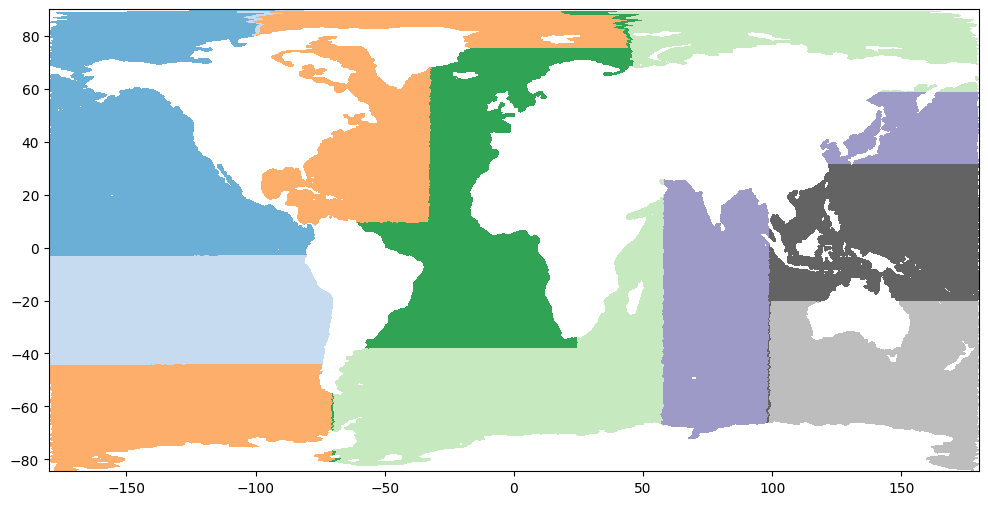

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (12,6))
def is_overlapping(tris, meshx):
    PIR = 180
    x1, x2, x3 = meshx[tris].T
    return np.logical_or(abs(x2 - x1) > PIR, abs(x3 - x1) > PIR, abs(x3 - x2) > PIR)
m = is_overlapping(tri_ ,x_)
ax.tricontourf(x_, y_, tri_[~m], np.arange(len(x)),cmap = 'tab20c')

#### finalise and save the new mesh dataset: 

using [thalassa](https://github.com/ec-jrc/Thalassa/blob/b9d977cd6999e73f5ad884e9e7b96d4041b60827/thalassa/normalization.py#L27)'s `GENERIC` Format

In [20]:
mesh_out = xr.Dataset({
    'lon': (['node'], x_),
    'lat': (['node'], y_),
    'triface_nodes': (['triface', 'three'], tri_),
    'depth': (['node'], mesh.B.isel(time=0).values[map_]),
})
mesh_out

<xarray.Dataset> Size: 3MB
Dimensions:        (node: 76064, triface: 147503, three: 3)
Dimensions without coordinates: node, triface, three
Data variables:
    lon            (node) float32 304kB -180.0 -119.2 -151.0 ... 172.1 177.9
    lat            (node) float32 304kB 90.0 89.45 88.96 ... -83.67 -84.07
    triface_nodes  (triface, three) int32 2MB 28287 28286 28196 ... 8449 8594
    depth          (node) float32 304kB 4.228e+03 2.633e+03 ... 107.0 254.0

check the depth assignation

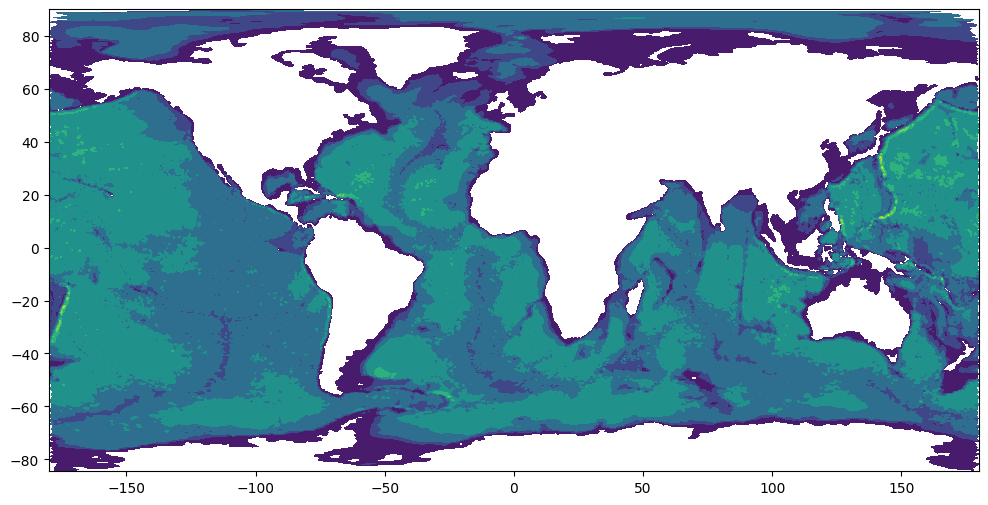

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (12,6))
ax.tricontourf(x_, y_, tri_[~m], mesh_out.depth)

#### export back to selafin

In [22]:
renumbered_mesh = xr.Dataset({
    "B": (("time", "node"), [mesh_out.depth.values]),
    },
    coords={
    "x": (['node'], x_),
    "y": (['node'], y_),
    "time": [pd.Timestamp.now()],
})
renumbered_mesh.attrs["variables"] = {"B": ("BOTTOM", "M") }
renumbered_mesh.attrs['ikle2'] = tri_ + 1
renumbered_mesh.selafin.write("global-v0.renumbered.slf")

### 2.3 interpolate meteo and append on to zarr file

we will load ERA5 reanalysis data and test the chunking size on the `time` and `node` dimensions: 
 * for the `time` dimension, the chunking is quite  straightforward.
 * for the `node` dimension, the chunking gets more complex because we deal with 2 different meshes. we will explain why in details below

In [23]:
# load  ERA5 reanalysis data
era5 = xr.open_dataset("era5_2023_uvp.nc")
era5

<xarray.Dataset> Size: 218GB
Dimensions:    (longitude: 1440, latitude: 721, time: 8760)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Data variables:
    msl        (time, latitude, longitude) float64 73GB ...
    u10        (time, latitude, longitude) float64 73GB ...
    v10        (time, latitude, longitude) float64 73GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-04 09:42:07 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

first we will the interpolation functions used in TELEMAC ( [`optim_gen-atm`](https://gitlab.pam-retd.fr/otm/telemac-mascaret/-/blob/optim-gen-atm/scripts/python3/utils/geometry.py) branch)

In [24]:
from scipy.spatial import Delaunay, cKDTree
def get_weights(in_xy, out_xy, d=2):
    t = Delaunay(in_xy) # triangulate output mesh
    s = t.find_simplex(out_xy) 
    vert = np.take(t.simplices, np.maximum(s, 0), axis=0)  # Use max to avoid negative indices
    t_ = np.take(t.transform, np.maximum(s, 0), axis=0)
    delta = out_xy - t_[:, d]
    bary = np.einsum('njk,nk->nj', t_[:, :d, :], delta)
    wgts = np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))
    # Points outside the out_xy
    out_idx_out = s < 0  
    if np.any(out_idx_out):
        # For points outside, find nearest neighbors
        tree = cKDTree(in_xy)
        _, in_idx_out = tree.query(out_xy[out_idx_out])
    else : 
        in_idx_out = None
    return vert, wgts, out_idx_out, in_idx_out


def interp(values, vtx, wts, out_idx_out, in_idx_out):
    res = np.einsum('nj,nj->n', np.take(values, vtx), wts)
    if in_idx_out is not None:
        res[out_idx_out] = values[in_idx_out]
    return res

here we will mimic the first function from above in order to append to a zarr store

In [25]:
# Function to subset ERA data based on the mesh extent
def subset_era_from_mesh(
    era: xr.Dataset,
    mesh: xr.Dataset,
    input360: bool,
    gtype: str,
) -> xr.Dataset:
    """
    Selects a subset of ERA data that overlaps with the provided mesh's geographical extent.

    :param era: The ERA dataset from which to select a subset.
    :param mesh: The mesh dataset defining the geographical extent for the subset selection.
    :param input360: A flag indicating whether the longitude should be adjusted to a 0-360 range.
    :return: A subset of the ERA dataset that falls within the mesh's geographical extent.
    """
    xmin, xmax, ymin, ymax = mesh.x.min(), mesh.x.max(), mesh.y.min(), mesh.y.max()
    if input360:
        xmin, xmax = np.mod(xmin + 360, 360), np.mod(xmax + 360, 360)
        if xmax < xmin:
            xmin, xmax = 0, 360
    if gtype == "grid":
        era_chunk = era.sel(longitude=slice(xmin, xmax), latitude=slice(ymax, ymin))
    else:  # for 01280 grid
        mask_lon = (era.longitude >= xmin) & (era.longitude <= xmax)
        mask_lat = (era.latitude >= ymin) & (era.latitude <= ymax)
        mask = mask_lon & mask_lat
        indices = np.where(mask)[0]
        era_chunk = era.isel(values=indices)
    return era_chunk


# Function to write meteorological data onto a mesh
def write_meteo_on_mesh(
    era_ds: xr.Dataset,
    mesh: xr.Dataset,
    file_out: str,
    n_time_chunk: int,
    n_node_chunk: int,
    input360: bool = True,
    gtype: str = "grid",
    ttype: str = "time",
) -> None:
    """
    Writes meteorological data from an ERA dataset onto a mesh and saves the result as a zarr file.

    :param era_ds: The ERA dataset with the meteorological data.
    :param mesh: The mesh dataset representing the spatial domain.
    :param file_out: The path to the output zarr file.
    :param n_time_chunk: The size of the time chunks for processing.
    :param n_node_chunk: The size of the node chunks for processing.
    :param input360: A flag indicating whether the longitude should be adjusted to a 0-360 range.
    """
    # Create the temporary dummy zarr file
    if os.path.exists(file_out):
        shutil.rmtree(file_out)
    x, y, tri = mesh.x.values, mesh.y.values, mesh.attrs["ikle2"] - 1
    nnodes = len(x)
    ntimes = len(era_ds.time)
    zero = da.zeros((ntimes, nnodes), chunks=(n_time_chunk, n_node_chunk))

    # Define coordinates and data variables for the output dataset
    coords = {
        "time": era_ds.time,
        "node": np.arange(nnodes),
        "lon": ("node", x),
        "lat": ("node", y),
        "triface_nodes": (("triface", "three"), tri),
    }
    data_vars = {}
    for varin in era_ds.data_vars:
        data_vars[varin] = (("time", "node"), zero)
    xr.Dataset(data_vars=data_vars, coords=coords).to_zarr(file_out, compute=False)

    # in the case of "tstps"
    if ttype == "step":
        t0 = pd.Timestamp(era_ds.time.values)
        seconds = era_ds.step.values / 1e9
        era_ds.time = pd.to_datetime(t0 + pd.Timedelta(seconds=seconds))

    # Iterate over nodes in chunks and write data to zarr file
    for ins in range(0, nnodes, n_node_chunk):
        end_node = min(ins + n_node_chunk, nnodes)
        node_chunk = np.arange(ins, end_node)
        mesh_chunk = mesh.isel(node=slice(ins, end_node))
        era_chunk = subset_era_from_mesh(era_ds, mesh_chunk, input360=input360, gtype=gtype)

        # Get weights for interpolation
        if gtype == "grid":
            nx1d = len(era_chunk.longitude)
            ny1d = len(era_chunk.latitude)
            xx = np.tile(era_chunk.longitude, ny1d).reshape(ny1d, nx1d).T.ravel()
            yy = np.tile(era_chunk.latitude, nx1d)
        else:  # for O1280 grids
            xx = era_chunk.longitude
            yy = era_chunk.latitude
            era_chunk = era_chunk.drop_vars(["number", "surface"])  # useless for meteo exports

        in_xy = np.vstack((xx, yy)).T
        if input360:
            in_xy[:, 0][in_xy[:, 0] > 180] -= 360
        out_xy = np.vstack((mesh_chunk.x, mesh_chunk.y)).T
        vert, wgts, u_x, g_x = get_weights(in_xy, out_xy)  # Assuming get_weights is defined elsewhere

        # Interpolate and write data for each variable and time chunk
        for var_name in era_chunk.data_vars:
            for it_chunk in range(0, ntimes, n_time_chunk):
                t_end = min(it_chunk + n_time_chunk, ntimes)
                time_chunk = era_chunk.time[it_chunk:t_end]
                data_chunk = da.zeros((len(time_chunk), len(node_chunk)), chunks=(n_time_chunk, n_node_chunk))
                for it, t_ in enumerate(time_chunk):
                    tmp = np.ravel(np.transpose(era_chunk.isel(time=it_chunk + it)[var_name].values))
                    data_chunk[it, :] = interp(tmp, vert, wgts, u_x, g_x)  # Assuming interp is defined elsewhere
                coords = {"time": time_chunk, "node": node_chunk}
                ds = xr.Dataset({var_name: (("time", "node"), data_chunk)}, coords=coords)
                region = {"time": slice(it_chunk, t_end), "node": slice(ins, end_node)}
                ds.to_zarr(file_out, mode="a-", region=region)

the script is ready, let's do a sensitivity on the nodes & times 

let's reduce first the dataset

In [26]:
era_test = era5.isel(time=slice(0,1000))

In [27]:
times_ = [50, 100, 200, 400, 1000]
nodes_ = [1000, 10000, len(renumbered_mesh.x)]

time_perf = np.zeros((len(times_), len(nodes_)))
sizes = np.zeros((len(times_), len(nodes_)))
for i_t, ttime in enumerate(times_): 
    for i_n, nnode in enumerate(nodes_):
        start = time.time()
        write_meteo_on_mesh(era_test, renumbered_mesh, "era5_2023_uvp.zarr", ttime, nnode)
        end = time.time()
        time_perf[i_t,i_n] =  end - start
        # calculate size
        bytes_per_element = zero.dtype.itemsize
        sizes[i_t,i_n] = ttime * nnode * bytes_per_element  / 1024 / 1000

visualise the performances

In [28]:
# Convert data for pcolormesh plots into a format compatible with hvplot
time_perf_mesh_df = pd.DataFrame(time_perf, index=times_, columns=nodes_)
sizes_mesh_df = pd.DataFrame(sizes, index=times_, columns=nodes_)

options = {
    "x":'columns', 
    "y":'index', 
    "C":'value', 
    "logx" : True, 
    "logy" : True, 
    "colorbar" : True, 
    "xlabel" : "chunk size for nodes", 
    "ylabel" :  "chunk size for times", 
    "width" :  500,
}

# Convert data for line plot into a Pandas DataFrame
sizes_flat = sizes.ravel()
time_perf_flat = time_perf.ravel()
idx = np.argsort(sizes_flat)
line_df = pd.DataFrame({
    'Size (MB)': sizes_flat[idx],
    'Time (sec)': time_perf_flat[idx]
})

# Create hvplot pcolormesh plots
time_perf_plot = time_perf_mesh_df.hvplot.heatmap(**options).opts(title = "Time taken for exports (in seconds)")
sizes_plot = sizes_mesh_df.hvplot.heatmap(**options).opts(title = "Size of each chunk (in MB)")

# Create hvplot line plot
line_plot = line_df.hvplot.line(
    x='Size (MB)', y='Time (sec)', 
    title='Time taken vs. Size of each chunk', width = 500)

# Combine plots into a layout
layout = (time_perf_plot + sizes_plot + line_plot).cols(3)

# Apply some options for better layout
layout.opts(
    opts.HeatMap(colorbar=True),
    opts.Layout(shared_axes=False, merge_tools=False),
)
# # Display the layout
hv.output(layout)

:Layout
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .HeatMap.II :HeatMap   [columns,index]   (value)
   .Curve.I    :Curve   [Size (MB)]   (Time (sec))

The best combination seems to be the **max number of nodes with the minimum number of times**

check if it worked: 

In [29]:
ds = xr.open_dataset("era5_2023_uvp.zarr", engine = "zarr")
ds

<xarray.Dataset> Size: 2GB
Dimensions:        (node: 76064, time: 1000, triface: 147503, three: 3)
Coordinates:
    lat            (node) float32 304kB ...
    lon            (node) float32 304kB ...
  * node           (node) int64 609kB 0 1 2 3 4 ... 76060 76061 76062 76063
  * time           (time) datetime64[ns] 8kB 2023-01-01 ... 2023-02-11T15:00:00
Dimensions without coordinates: triface, three
Data variables:
    msl            (time, node) float64 609MB ...
    triface_nodes  (triface, three) int32 2MB ...
    u10            (time, node) float64 609MB ...
    v10            (time, node) float64 609MB ...

In [30]:
import thalassa
import geoviews as gv
ds = thalassa.normalize(ds)
# Convert the node data in "Tabular" format: https://holoviews.org/user_guide/Tabular_Datasets.html
df = ds[["lon", "lat", "node"]].to_dataframe().reset_index()
# Create a geoviews Points object
gv_points = gv.Points(df, kdims=["lon", "lat"], vdims=["node"]).opts(size = 1, color='k')
# Create a Dynamic map with the variable you want, e.g. "depth"
raster_dmap = thalassa.plot(ds.sel(time = "2023-08-27", method="nearest"), "u10")
# now combine the raster with the points
combined_dmap = raster_dmap * gv_points
# plot
combined_dmap.opts(tools=["hover"], width=1200, height=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7d813915-6c7a-4327-b1b5-a07c50422b67': {'version…

#### finally, convert to Selafin

In [31]:
def remove(path):
    try:
        if os.path.isfile(path):
            os.remove(path)  # Remove a file
        elif os.path.isdir(path):
            if not os.listdir(path):  # Check if the directory is empty
                os.rmdir(path)
            else:
                shutil.rmtree(path)
    except OSError as e:
        print(f"Error: {e.strerror}")
        

def write_meteo_selafin(outpath, input_atm_zarr):
    xatm = xr.open_dataset(input_atm_zarr, engine="zarr")
    t0 = pd.Timestamp(xatm.time.values[0])
    # Define a mapping from the original variable names to the new ones
    var_map = {
        "u10": ("WINDX", "M/S"),
        "v10": ("WINDY", "M/S"),
        "msl": ("PATM", "PASCAL"),
        "tmp": ("TAIR", "DEGREES C"),
    }
    var_attrs = {}
    for var in xatm.data_vars:
        if var in var_map:
            # Attributes for the variable
            var_attrs[var] = (var_map[var][0], var_map[var][1])
    # Add global attributes after concatenation
    xatm.attrs["date_start"] = [t0.year, t0.month, t0.day, t0.hour, t0.minute, t0.second]
    xatm.attrs["ikle2"] = xatm.triface_nodes.values + 1
    xatm.attrs["variables"] = {var: attrs for var, attrs in var_attrs.items()}
    xatm = xatm.rename({"lon": "x", "lat": "y"})
    xatm = xatm.drop_vars(["triface_nodes"])
    xatm.selafin.write(outpath)
    # remove(input_atm_zarr)

In [32]:
write_meteo_selafin("era5_2023_uvp.slf", "era5_2023_uvp.zarr")

test with O1280 grid: 

In [33]:
O1280_test = xr.open_dataset("2023-09-01.uvp.O1280.zarr", engine = "zarr")
O1280_test

<xarray.Dataset> Size: 57GB
Dimensions:    (values: 6599680, time: 720)
Coordinates:
    latitude   (values) float64 53MB ...
    longitude  (values) float64 53MB ...
    number     int64 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2023-09-01 ... 2023-09-30T23:00:00
  * values     (values) int64 53MB 0 1 2 3 4 ... 6599676 6599677 6599678 6599679
Data variables:
    msl        (time, values) float32 19GB ...
    u10        (time, values) float32 19GB ...
    v10        (time, values) float32 19GB ...

In [34]:
nnode = len(renumbered_mesh.x)
write_meteo_on_mesh(O1280_test, renumbered_mesh, "01280_v0.zarr", 50, nnode, input360=True, gtype='tri')

In [35]:
write_meteo_selafin("01280_202309_uvp.slf", "01280_v0.zarr")

it works !! (GIF you see at the beginning of the notebook)